In [1]:
import cv2
import numpy as np
import struct
import time
import matplotlib.pyplot as plt
import os
import re
import sys
from pathlib import Path

from read_cine import read_cine, convert_cine_to_avi
from track_object import track_object
from main import extract_calibration, detect_chamber

In [3]:
cine_path = r"E:\good_data\He3kA_B250G500G_pl0t20_uw15t35_P30\Y20241102_P30_z13_x200_y0@20_020.cine"
avi_path = os.path.join(os.getcwd(), "temp_video.avi")

time_arr, frame_arr = read_cine(cine_path)

convert_cine_to_avi(frame_arr, avi_path)

# Extract calibration from filename
calibration = extract_calibration(cine_path)

# Open AVI file for chamber detection
cap = cv2.VideoCapture(avi_path)
ret, initial_frame = cap.read()
if not ret:
    raise ValueError(f"Could not read first frame for chamber detection")

# Detect chamber
(cx, cy), chamber_radius = detect_chamber(initial_frame, calibration)
cap.release()

Reading .cine file...
Done reading .cine file (3.7 s)
Converting to c:\Users\hjia9\Documents\GitHub\data-analysis\object_tracking\temp_video.avi...
Progress: 100/1001 frames
Progress: 200/1001 frames
Progress: 300/1001 frames
Progress: 400/1001 frames
Progress: 500/1001 frames
Progress: 600/1001 frames
Progress: 700/1001 frames
Progress: 800/1001 frames
Progress: 900/1001 frames
Progress: 1000/1001 frames
Progress: 1001/1001 frames
Conversion complete. Saved to c:\Users\hjia9\Documents\GitHub\data-analysis\object_tracking\temp_video.avi
Hough failed, using contour fallback
Chamber detected at (1120, 1113) with radius 609px


In [5]:
pos_arr, time_arr = track_object(avi_path, time_arr, calibration, cx, cy, chamber_radius)

Processed 76 positions


Found 1 zero crossings
Zero crossing #1: Time = 0.002s, Y position = -0.169cm


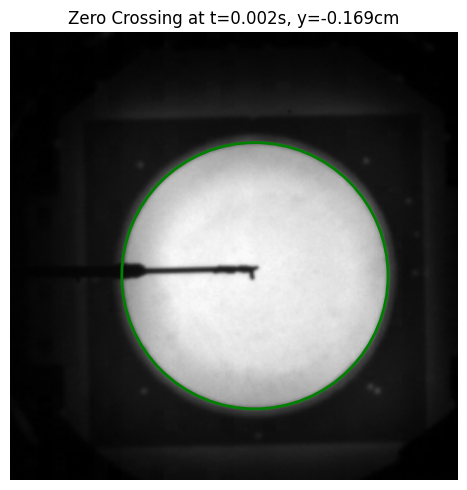

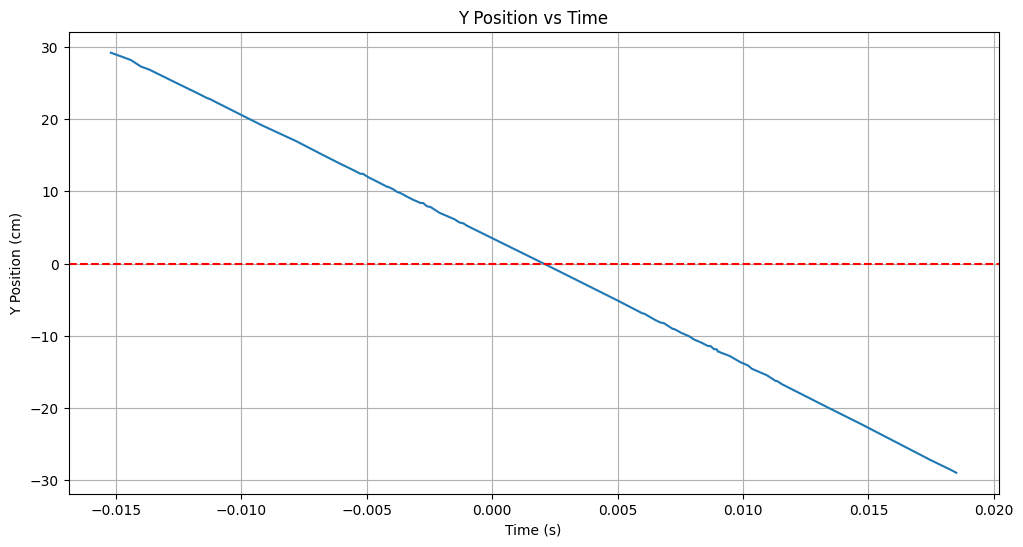

In [ ]:
# Find frames where y position crosses zero
y_positions = pos_arr[:, 1]  # Get all y positions
zero_crossings = []
zero_crossing_frames = []
zero_crossing_times = []

for i in range(1, len(y_positions)):
    # Check if the y position crosses zero between this frame and the previous one
    if (y_positions[i-1] < 0 and y_positions[i] >= 0) or (y_positions[i-1] >= 0 and y_positions[i] < 0):
        zero_crossings.append(i)
        zero_crossing_times.append(time_arr[i])

print(f"Found {len(zero_crossings)} zero crossings")

# Display frames where y position crosses zero
cap = cv2.VideoCapture(avi_path)
if len(zero_crossings) > 0:
    # Display up to 3 zero crossing frames
    num_to_display = min(3, len(zero_crossings))
    plt.figure(figsize=(15, 5*num_to_display))
    
    for i in range(num_to_display):
        crossing_idx = zero_crossings[i]
        frame_num = crossing_idx
        
        # Get the frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if ret:
            # Get the corresponding time and position
            crossing_time = time_arr[crossing_idx]
            crossing_y = y_positions[crossing_idx]
            
            # Draw the chamber and estimated position
            drawing = frame.copy()
            cv2.circle(drawing, (cx, cy), chamber_radius, (0, 255, 0), 2)
            
            # Convert back from relative coordinates to pixel coordinates
            ball_x = int(cx + pos_arr[crossing_idx, 0] / calibration)
            ball_y = int(cy - pos_arr[crossing_idx, 1] / calibration)  # Note: Y is inverted
            
            # Display the original frame
            plt.subplot(num_to_display, 1, i+1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
            # Draw the chamber as a circle
            chamber_circle = plt.Circle((cx, cy), chamber_radius, fill=False, color='green', linewidth=2)
            plt.gca().add_patch(chamber_circle)
            
            plt.title(f"Zero Crossing at t={crossing_time:.3f}s, y={crossing_y:.3f}cm")
            plt.axis('off')
            
            print(f"Zero crossing #{i+1}: Time = {crossing_time:.3f}s, Y position = {crossing_y:.3f}cm")
            plt.tight_layout()

else:
    print("No zero crossings found!")

cap.release()

# Plot the y position over time to visualize zero crossings
plt.figure(figsize=(12, 6))
plt.plot(time_arr, y_positions)
plt.title('Y Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Y Position (cm)')
plt.grid(True)
